## Figure of Merit Prototype for Section 4.3: Detection of pre-SN variability for Galactic Supernova science case ##

** 2016-01-30 (WIC): ** Read in previously-computed metrics and combine their values to come up with a prototype figure of merit for the "Galactic Supernova" science case. 

Making the assumption that a core-collapse supernova would be detected directly by neutrino experiments, triggering intensive followup at all wavelengths, I adopt the detectability of an $\sim$ 8 mag nova-like outburst *before* the supernova (parameters similar to SN2010mc; Ofek et al. 2013 Nature) as a figure of merit for LSST's contribution to this science. 

I assume that the probability of a supernova going off at a given location scales with the number of stars along the line of sight (out to a fiducial distance, which I set at 80 kpc to avoid much of the halo and the Magellanic Clouds in the figure of merit). Multiplying (fraction detected) $\times$ (star count) at each position then yields a rough figure of merit for the use of LSST to detect pre-Supernova variability.

**Implementation:**

I use a slightly modified version of Mike Lund's Starcounts maf_contrib module to produce the stellar density out to some fiducial distance, then use Peter Yoachim's TransientMetric to assess the fraction of *pre*-Supernova outbursts that might be detected. The intention here is to provide a simple example using pre-computed metrics into a figure of merit to provoke the community of LSST-interested Milky Way observers. 

Imports inside subsections are needed only to run the cells in those subsections.

**2016-04-10 (WIC):** Updated the paths to previous output to follow the github repository structure. The easiest way to run these having downloaded the repo is probably to cd to the subdirectory 'fomOutputs' , which will hold the outputs of the figures of merit including plots. This keeps figure-of-merit output separate from the previously-run metrics, as well as from the python and notebook directories. 

Second update: no that would get messy. Instead, we do the following:

* Directory from which this notebook is called is given a variable 'wDir' so that we can easily go back there after running the metrics;

* The top-level directory for the metric outputs is set as a variable. Inputs pulled from the repo are relative to this directory.
    * (There might be a clever jupyter-related way to get the parent directory from the notebook itself. However that would probably break if you're running a copy of the original notebook somewhere else to test. Setting a variable is probably much safer!)
    
Similar considerations apply for the opsim databases (if calling starcounts metric)

**2016-04-24 (WIC)**: updated again with the replacements enigma_1189 --> minion_1016 and ops2_1092 --> minion_1020. The meaning of **topDir** has been changed: it now points to the directory where metric results are stored. I decided that having repository directories populated straight from a notebook that the user is used for experimentation, could get very messy indeed.

In [1]:
# repoDir = '/Users/clarkson/Progs/Projects/lsstScratchWIC'   # wherever you put the repository
#topDir = '/Users/clarkson/Data/LSST/MetricsEtc/'   # Wherever you put the results of the transients metric
topDir = '/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411'

In [2]:
# For reference, here are the parameters used to simulate the transients:
#peaks = {'uPeak':11, 'gPeak':9, 'rPeak':8, 'iPeak':7, 'zPeak':6,'yPeak':6}
#colors = ['b','g','r','purple','y','magenta','k']
#filterNames = ['u','g','r','i','z','y']
## Timing parameters of the outbursts
#riseSlope = -2.4
#declineSlope = 0.05  # following Ofek et al. 2013
#transDuration = 80.
#peakTime = 20.

# relevant parameter for the TransientMetric:
# nPhaseCheck=20

# Additionally, all filters were used (passed as **peaks to the TransientMetric).

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import time

In [5]:
# Some colormaps we might use
import matplotlib.cm as cm

In [6]:
# Capability to load previously-computed metrics, examine them
import lsst.sims.maf.metricBundles as mb

# plotting (to help assess the results)
import lsst.sims.maf.plots as plots

In [7]:
import os

### Setting the paths appropriately ###

In [8]:
# Directory where we started everyhing. Outputs go in subdirectories of wDir:
wDir = os.getcwd() 

# Uncomment the following if you want the outputs from your run to go up to the repository
# wDir = '%s/data/fomOutputs' % (topDir) 

print wDir

/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411


In [9]:
# Default is to assume the opsim databases are symlinked into the current directory.
#opsimDir = os.getcwd()

# uncomment the following to set the directory on your system where the opsim runs are stored:
# opsimDir = '/Users/clarkson/Data/LSST/OpSimRuns/Runs_20151229/LocalCopies'
opsimDir = '/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411'

### Slightly modified version of the Starcounts metric ###

In [10]:
# The example CountMetric provided by Mike Lund seems to have the column indices for coords
# hardcoded (which breaks the examples I try on my setup). This version finds the co-ordinates by 
# name instead. First the imports we need:
# import numpy as np
from lsst.sims.maf.metrics import BaseMetric
#from mafContrib import starcount 

# WIC - sims_maf_contrib is no longer recognized by my system. I had to copy the StarCounts module into
# the working directory. So:
from StarCounts import starcount

In [11]:
class AsCountMetric(BaseMetric):

    """
    WIC - Lightly modified copy of Mike Lund's example StarCounts metric in sims_maf_contrib. 
    Accepts the RA, DEC column names as keyword arguments. Docstring from the original:
    
    Find the number of stars in a given field between distNear and distFar in parsecs. 
    Field centers are read from columns raCol and decCol.
    """
    
    def __init__(self,**kwargs):
        
        self.distNear=kwargs.pop('distNear', 100)
        self.distFar=kwargs.pop('distFar', 1000)
        self.raCol=kwargs.pop('raCol', 'ra')
        self.decCol=kwargs.pop('decCol', 'dec')
        super(AsCountMetric, self).__init__(col=[], **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        sliceRA = np.degrees(slicePoint[self.raCol])
        sliceDEC = np.degrees(slicePoint[self.decCol])
        return starcount.starcount(sliceRA, sliceDEC, self.distNear, self.distFar)

### Run the counts metric out to a fiducial distance ###

(This section can be ignored if the Counts metric was already computed.) We do not do plots or summary statistics, since we should be able to evaluate those later on. 

In [12]:
# Go from the notebook directory to the METRIC outputs directory
# os.chdir('%s/data/metricOutputs' % (reppDir))  # I do not recommend using this. 
os.chdir(topDir)

In [13]:
distNear=10.
distFar = 8.0e4  # Get most of the plane but not the Magellanic clouds 

In [14]:
import lsst.sims.maf.slicers as slicers

In [15]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [16]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [17]:
metricCount=AsCountMetric(distNear=distNear, distFar=distFar)
metricList = [metricCount]

In [18]:
runNamePSlike = 'minion_1020'
sqlconstraintCount = 'filter = "r" and night < 2000'  # Assume everywhere visited once in 5.5 years...
bDictPSlike={}
for i,metric in enumerate(metricList):
    bDictPSlike[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraintCount, 
                                          runName=runNamePSlike)
opsdbPSlike = db.OpsimDatabase(opsimDir + '/' + runNamePSlike + '_sqlite.db')
outDirPSlike = '%s/TestCountOnly_PSlike' % (topDir)
resultsDbPSlike = db.ResultsDb(outDir=outDirPSlike)

In [19]:
print opsimDir + '/' + runNamePSlike + '_sqlite.db'
! ls /Users/clarkson/Data/LSST/OpSimRuns/opsim20160411/minion_1020_sqlite.db

/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411/minion_1020_sqlite.db
/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411/minion_1020_sqlite.db


In [20]:
tStart = time.time()
bgroupPSlike = metricBundles.MetricBundleGroup(bDictPSlike, opsdbPSlike, outDir=outDirPSlike, \
                                             resultsDb=resultsDbPSlike)
bgroupPSlike.runAll()
tPostPSlike = time.time()
print "Time spent Counting PSlike: %.3e seconds" % (tPostPSlike - tStart)

Querying database with constraint filter = "r" and night < 2000
Found 294752 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Time spent Counting PSlike: 3.548e+01 seconds


In [21]:
# Ensure the output file actually got written...
! ls -l ./TestCountOnly_PSlike/*npz

-rw-r--r--  1 clarkson  staff  1624904 Apr 24 19:45 ./TestCountOnly_PSlike/minion_1020_AsCount_r_and_night_lt_2000_HEAL.npz


In [22]:
# We will need the same counts information for the baseline survey if we want to normalize by 
# total counts in the survey area. So let's run the above for minion_1016 as well.
runNameBaseline = 'minion_1016'
bDictBaseline={}
for i,metric in enumerate(metricList):
    bDictBaseline[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraintCount, 
                                          runName=runNameBaseline)
opsdbBaseline = db.OpsimDatabase(opsimDir + '/' + runNameBaseline + '_sqlite.db')
outDirBaseline = '%s/TestCountOnly_Baseline' % (topDir)
resultsDbBaseline = db.ResultsDb(outDir=outDirBaseline)

tStart = time.time()
bgroupBaseline = metricBundles.MetricBundleGroup(bDictBaseline, opsdbBaseline, outDir=outDirBaseline, \
                                             resultsDb=resultsDbBaseline)
bgroupBaseline.runAll()
tPostBaseline = time.time()
print "Time spent Counting Baseline: %.3e seconds" % (tPostBaseline - tStart)


Querying database with constraint filter = "r" and night < 2000
Found 297867 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Time spent Counting Baseline: 4.981e+01 seconds


In [23]:
! ls ./TestCountOnly_Baseline/minion_1016_AsCount_r_HEAL.npz

ls: ./TestCountOnly_Baseline/minion_1016_AsCount_r_HEAL.npz: No such file or directory


### Loading the pre-computed metrics: Counts and Transients ###

In [24]:
# go back to figure-of-merit output directory
os.chdir(wDir)

In [25]:
pathCount='%s/TestCountOnly_PSlike/minion_1020_AsCount_r_and_night_lt_2000_HEAL.npz' % (topDir)
pathTransient='%s/TransientsLike2010mc_PSlike/minion_1020_Alert_sawtooth_HEAL.npz' % (topDir)

In [26]:
#Initialize then load
bundleCount = mb.createEmptyMetricBundle()
bundleTrans = mb.createEmptyMetricBundle()

bundleCount.read(pathCount)
bundleTrans.read(pathTransient)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [27]:
# Set a mask for the BAD values of the transient metric
bTrans = (np.isnan(bundleTrans.metricValues)) | (bundleTrans.metricValues <= 0.)
bundleTrans.metricValues.mask[bTrans] = True

### Normalizing the counts metric for OpSim runs with different total area ###

The two runs compared, minion_1016 and opsPSlike, cover different total areas. Before proceeding further, we read in the counts metric for minion_1016 in order to compare the total number of stars.

In [28]:
# Read in the stellar density for Baseline so that we can compare the total NStars...
pathCountBaseline='%s/TestCountOnly_Baseline/minion_1016_AsCount_r_and_night_lt_2000_HEAL.npz' % (topDir)
bundleCountBaseline = mb.createEmptyMetricBundle()
bundleCountBaseline.read(pathCountBaseline)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [29]:
# Do the comparison
nTotPSlike = np.sum(bundleCount.metricValues)
nTotBaseline = np.sum(bundleCountBaseline.metricValues)
print "Total NStars - minion_1020: %.3e - minion_1016 %.3e" % (nTotPSlike, nTotBaseline)

Total NStars - minion_1020: 3.692e+10 - minion_1016 3.793e+10


There is a difference between the total NStars (out to 80kpc) but it's on the order of 1%, even though minion_1016 covers more of the plane exterior to the Sun. This is probably an expression of the dominance of the central regions of the Milky Way galaxy in the density model.

To express the figure of merit as a fraction of detected pre-outbursts that would be detected by LSST, we divide the density metric for each run by its own total NStars. Thus the figure of merit will take the range $0 - 1$.

### Multiply the metric value sets together for minion_1020 ###

I think the best way to ensure that the result has all the pieces needed by maf is to create a copy of one of the metrics, then re-read the metric in. Since we don't trust negative values of the transient metric, use the mask for non-negative transient values too.

In [30]:
bundleProc = mb.createEmptyMetricBundle()
bundleProc.read(pathTransient)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [31]:
# Set the mask
bundleProc.metricValues.mask[bTrans] = True

In [32]:
# Multiply the two together, normalise by the total starcounts over the survey
bundleProc.metricValues = (bundleCount.metricValues * bundleTrans.metricValues) 
bundleProc.metricValues /= np.sum(bundleCount.metricValues)

In [33]:
bundleProc.metric.name = '(sawtooth alert) x (counts) / NStars_total'

In [34]:
FoMPSlike = np.sum(bundleProc.metricValues)
print "FoM PSlike: %.2e" % (FoMPSlike)

FoM PSlike: 8.26e-01


### Multiply the two metrics together for minion_1016 ###

In [35]:
pathCountBaseline='%s/TestCountOnly_Baseline/minion_1016_AsCount_r_and_night_lt_2000_HEAL.npz' % (topDir)
pathTransBaseline='%s/TransientsLike2010mc_Baseline/minion_1016_Alert_sawtooth_HEAL.npz' % (topDir)
bundleCountBaseline = mb.createEmptyMetricBundle()
bundleTransBaseline = mb.createEmptyMetricBundle()

bundleCountBaseline.read(pathCountBaseline)
bundleTransBaseline.read(pathTransBaseline)
bTransBaseline = (np.isnan(bundleTransBaseline.metricValues)) | (bundleTransBaseline.metricValues <= 0.)
bundleTransBaseline.metricValues.mask[bTransBaseline] = True

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [36]:
# Load Baseline-like metric bundle and replace its values with processed values
bundleProcBaseline = mb.createEmptyMetricBundle()
bundleProcBaseline.read(pathTransBaseline)
bundleProcBaseline.metricValues.mask[bTransBaseline] = True

bundleProcBaseline.metricValues = (bundleCountBaseline.metricValues * bundleTransBaseline.metricValues) 
bundleProcBaseline.metricValues /= np.sum(bundleCountBaseline.metricValues)
bundleProcBaseline.metric.name = '(sawtooth alert) x (counts) / NStars_total'

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [37]:
FoMBaseline = np.sum(bundleProcBaseline.metricValues)
print FoMBaseline

0.128922471359


### Our "result:" f = (Sawtooth alert) $\times$ ($\rho_{\ast}$) for the two runs ###

In [38]:
# Print the sum total of our f.o.m. for each run
print "FOM for minion_1020: %.3f" % (FoMPSlike)
print "FOM for minion_1016: %.3f" % (FoMBaseline)

FOM for minion_1020: 0.826
FOM for minion_1016: 0.129


### Plot the processed metrics ###

In [39]:
# Same plot information as before:
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
plotDictProc={'logScale':True, 'cmap':cm.cubehelix_r}
bundleProc.setPlotDict(plotDictProc)
bundleProc.setPlotFuncs(plotFuncs)

plotDictProc={'logScale':True, 'cmap':cm.cubehelix_r}
bundleProcBaseline.setPlotDict(plotDictProc)
bundleProcBaseline.setPlotFuncs(plotFuncs)


/Users/clarkson/Progs/python/LSST/sims_maf_github/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 28498 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/clarkson/Progs/python/LSST/sims_maf_github/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 2326 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


{'Histogram': 4, 'SkyMap': 3}

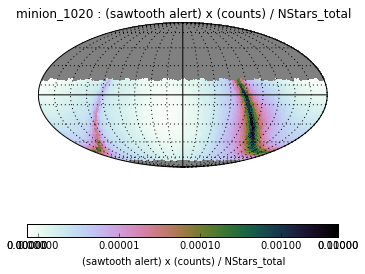

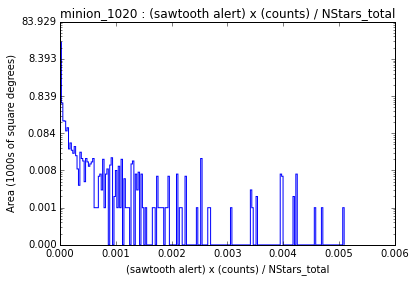

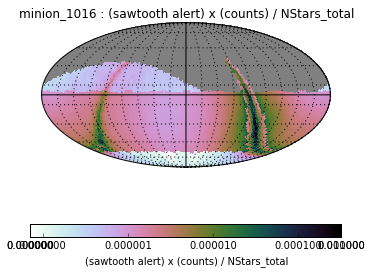

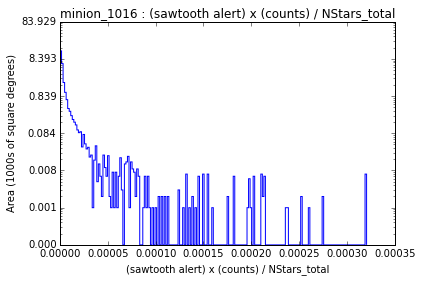

In [40]:
bundleProc.plot(savefig=True)
bundleProcBaseline.plot(savefig=True)

### Plot the two input metrics ###

In [41]:
# Plot just the spatial map and the histogram for the two. Use different colormaps for each.
#plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
bundleTrans.setPlotFuncs(plotFuncs)
bundleCount.setPlotFuncs(plotFuncs)

In [42]:
# Use a different colormap for each so we can tell them apart easily...
plotDictCount={'logScale':True, 'cmap':cm.gray_r}
plotDictTrans={'logScale':False, 'cmap':cm.RdBu_r}
bundleCount.setPlotDict(plotDictCount)
bundleTrans.setPlotDict(plotDictTrans)

In [43]:
plotDictCount={'logScale':True, 'cmap':cm.gray_r}
plotDictTrans={'logScale':False, 'cmap':cm.RdBu_r}
bundleCountBaseline.setPlotDict(plotDictCount)
bundleTransBaseline.setPlotDict(plotDictTrans)
bundleTransBaseline.setPlotFuncs(plotFuncs)
bundleCountBaseline.setPlotFuncs(plotFuncs)

/Users/clarkson/Progs/python/LSST/sims_maf_github/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 26622 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


{'Histogram': 4, 'SkyMap': 3}

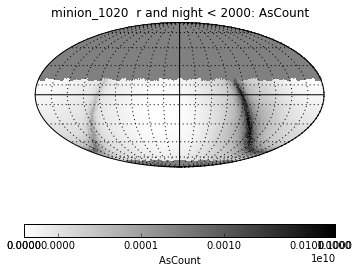

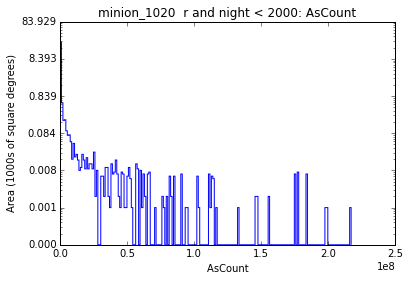

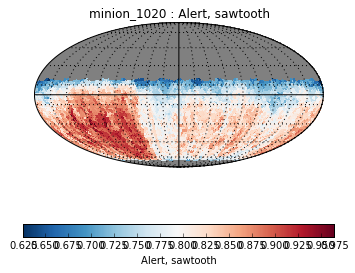

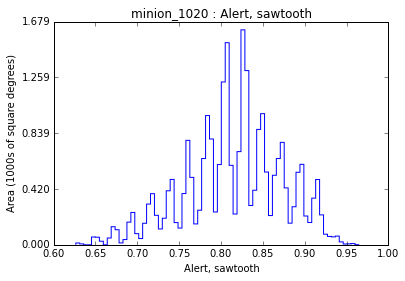

In [44]:
bundleCount.plot()
bundleTrans.plot()

/Users/clarkson/Progs/python/LSST/sims_maf_github/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 29652 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


{'Histogram': 4, 'SkyMap': 3}

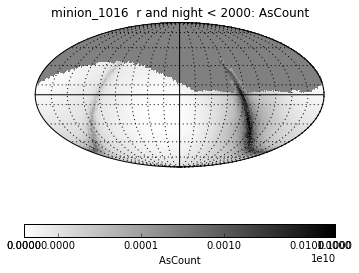

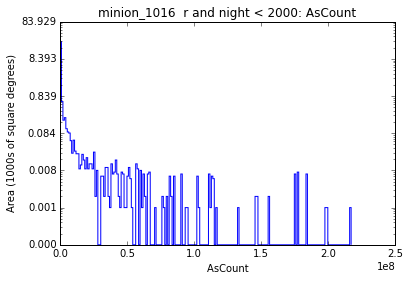

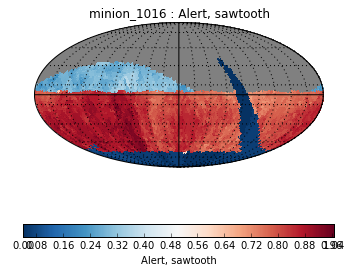

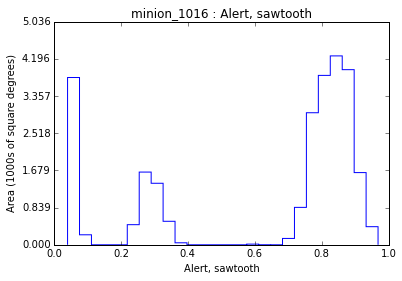

In [45]:
bundleCountBaseline.plot()
bundleTransBaseline.plot()